In [2]:
import numpy as np
import pandas as pd
import pandas
import geopandas as gpd
import requests
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import maup
from statistics import mean, median
from shapely.geometry import Polygon
from shapely.ops import cascaded_union

In [3]:
maup.progress.enabled = True
np.set_printoptions(threshold=np.inf)

**Precinct shapefile from Kaggle**

In [4]:
precincts = gpd.read_file("az_vtd_2018_new_pima.shp")

In [5]:
proj = precincts.crs

Here 'LP' has 12 precincts, but the county's election website and tabular election data indicate only 11 precincts. This is because the Alamo precinct was merged into the Wenden precinct.

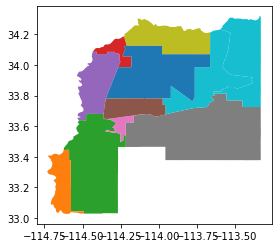

In [6]:
# Merge Alamo into Wenden
import descartes
Alamo = precincts.loc[110,]["geometry"]
Wenden = precincts.loc[362,]["geometry"]
merged = [Alamo, Wenden]
merged = cascaded_union(merged)
precincts.at[362,"geometry"] = merged
precincts.drop(110, inplace = True)
LaPaz = precincts[precincts.cde_county=="LP"]
LaPaz.plot(column = "precinctna") # This matches the map on the county's election website

**Block-level shapefile from Census Website**

In [7]:
blocks = gpd.read_file("tl_2017_04_tabblock10.shp")

In [8]:
blocks = blocks.to_crs(proj)

**Tabular election data from the MIT Election Data Science Lab**

In [9]:
# Dataset: State Precinct-Level Returns 2018
election = pd.read_csv("precinct_2018.csv", encoding="ISO-8859-1", dtype = {"precinct":str, "party":str, "district":str, "writein":str})
election = election[election.state_fips == 4]

In [10]:
# Filter out elections of interest
election_2018 = election[
    (election.office == 'Attorney General')|
    (election.office == 'Governor')|
    (election.office == 'Secretary Of State')|
    (election.office == 'State Senate')|
    (election.office == 'State Treasurer')|
    (election.office == 'US House')|
    (election.office == 'US Senate')]

elect_pivoted = election_2018.pivot_table(index = ['precinct'], columns = ['office','party'], values = ['votes'])
elect_pivoted.columns = [' '.join(col).strip() for col in elect_pivoted.columns.values]
elect_pivoted = elect_pivoted.iloc[:,[0,2,3,6,7,9,10,14,15,17,18,19,21,22,25]]

elect_pivoted.columns = ['AG18D', 'AG18R',
       'GOV18D', 'GOV18R', 'SOS18D', 'SOS18R', 'SSEN18D', 'SSEN18R', 'TRE18D',
       'TRE18R', 'USH18D', 'USH18G', 'USH18R', 'SEN18D', 'SEN18R']

elect_pivoted

,AG18D,AG18R,GOV18D,GOV18R,SOS18D,SOS18R,SSEN18D,SSEN18R,TRE18D,TRE18R,USH18D,USH18G,USH18R,SEN18D,SEN18R
precinct,,,,,,,,,,,,,,,
0 DESERT CEDARS,593.0,552.0,504.0,620.0,604.0,546.0,585.0,536.0,552.0,584.0,618.0,NaN,522.0,594.0,529.0
0 Ehrenberg,46.0,163.0,35.0,168.0,51.0,159.0,44.0,166.0,42.0,165.0,41.0,5.0,162.0,44.0,161.0
0001 ACACIA,1125.0,1021.0,989.0,1102.0,1199.0,950.0,1029.0,881.0,1079.0,1059.0,1126.0,NaN,1013.0,1209.0,891.0
0002 ACOMA,693.0,1354.0,614.0,1440.0,769.0,1284.0,NaN,1168.0,604.0,1415.0,814.0,NaN,1280.0,757.0,1305.0
0003 ACUNA,1012.0,215.0,930.0,286.0,1027.0,195.0,1099.0,NaN,992.0,223.0,1080.0,103.0,NaN,1032.0,167.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Williams Northside 98,386.0,1056.0,340.0,1110.0,434.0,1026.0,405.0,1046.0,368.0,1057.0,471.0,NaN,984.0,425.0,1006.0
Williams Southside 99,214.0,375.0,172.0,420.0,229.0,369.0,213.0,382.0,207.0,383.0,243.0,NaN,359.0,225.0,363.0
Winona 92,557.0,629.0,518.0,657.0,578.0,608.0,575.0,600.0,542.0,637.0,617.0,NaN,584.0,590.0,582.0


In [ ]:
**Block level demographic data for the 2010 Decennial Census from Census API**

In [11]:
variables = [
    # pop
    "P001001",
    "P005003",
    "P005004",
    "P005005",
    "P005006",
    "P005007",
    "P005008",
    "P005009",
    "P005010",
    "P005011",
    "P005012",
    "P005013",
    "P005014",
    "P005015",
    "P005016",
    "P005017",
    # vap
    "P011001",
    "P011002",
    "P011005",
    "P011006",
    "P011007",
    "P011008",
    "P011009",
    "P011010",
    "P011011",
]

keys = [
    # pop
    "TOTPOP",
    "NH_WHITE",
    "NH_BLACK",
    "NH_AMIN ",
    "NH_ASIAN",
    "NH_NHPI ",
    "NH_OTHER",
    "NH_2MORE",
    "HISP",
    "H_WHITE",
    "H_BLACK",
    "H_AMIN ",
    "H_ASIAN",
    "H_NHPI ",
    "H_OTHER",
    "H_2MORE",
    # vap
    "VAP",
    "HVAP",
    "WVAP",
    "BVAP",
    "AMINVAP",
    "ASIANVAP",
    "NHPIVAP",
    "OTHERVAP",
    "2MOREVAP",
]

def counties(state_fips):
    resp = requests.get(
        "https://api.census.gov/data/2010/dec/sf1"
        "?get=NAME&for=county:*&in=state:{}".format(state_fips)
    )
    header, *rows = resp.json()
    county_column_index = header.index("county")
    county_fips_codes = set(row[county_column_index] for row in rows)
    return county_fips_codes

def block_data_for_county(state_fips, county_fips, variables=variables, keys=keys):
    url = (
        "https://api.census.gov/data/2010/dec/sf1"
        + "?get={},NAME&for=block:*".format(",".join(variables))
        + "&in=state:{}&in=county:{}&in=tract:*".format(state_fips, county_fips)
    )
    resp = requests.get(url)
    header, *rows = resp.json()
    variable_lookup = dict(zip(variables, keys))
    columns = [variable_lookup.get(column_name, column_name) for column_name in header]
    dtypes = {key: int for key in keys}
    dtypes.update({key: str for key in ["state", "county", "tract", "block"]})
    data = pandas.DataFrame.from_records(rows, columns=columns).astype(dtypes)
    data["geoid"] = data["state"] + data["county"] + data["tract"] + data["block"]
    return data

def block_data_for_state(state_fips):
    county_fips_codes = counties(state_fips)
    return pandas.concat(
        [
            block_data_for_county(state_fips, county_fips)
            for county_fips in tqdm(county_fips_codes)
        ]
    )

In [12]:
demo = block_data_for_state('04') # For AZ only

**Merge block-level shapefile and demographic data**

In [13]:
blocks["geoid"] = blocks.GEOID10
block_demo = pd.merge(blocks, demo, on='geoid', how='left', indicator=True)
block_demo = block_demo.drop(columns = "geoid")

**Aggregate blocks to precincts**

In [14]:
block_demo.head()

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,NAME10,MTFCC10,UR10,UACE10,UATYPE,...,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,NAME,state,county,tract,block,_merge
0,04,023,966000,1107,040239660001107,Block 1107,G5040,R,None,None,...,0,0,0,0,"Block 1107, Block Group 1, Census Tract 9660, ...",04,023,966000,1107,both
1,04,023,966000,1123,040239660001123,Block 1123,G5040,R,None,None,...,0,0,0,0,"Block 1123, Block Group 1, Census Tract 9660, ...",04,023,966000,1123,both
2,04,023,966000,1040,040239660001040,Block 1040,G5040,R,None,None,...,0,0,0,0,"Block 1040, Block Group 1, Census Tract 9660, ...",04,023,966000,1040,both
3,04,023,966000,3006,040239660003006,Block 3006,G5040,R,None,None,...,0,0,0,0,"Block 3006, Block Group 3, Census Tract 9660, ...",04,023,966000,3006,both
4,04,003,000203,1131,040030002031131,Block 1131,G5040,R,None,None,...,0,0,0,0,"Block 1131, Block Group 1, Census Tract 2.03, ...",04,003,000203,1131,both


In [15]:
precincts.head()

,pctnum,precinctna,cde_county,DIST_CON,DIST_LEG,geometry
0,AP0002,ALPINE,AP,NaN,NaN,"POLYGON ((-109.49567 33.65280, -109.49576 33.6..."
1,AP0003,CANYON DE CHELLY,AP,NaN,NaN,"POLYGON ((-109.71666 36.26151, -109.71658 36.2..."
2,AP0005,CHINLE,AP,NaN,NaN,"POLYGON ((-109.81183 36.27512, -109.80810 36.2..."
3,AP0009,CONCHO,AP,NaN,NaN,"POLYGON ((-109.53982 34.44871, -109.53928 34.4..."
4,AP0011,COTTONWOOD,AP,NaN,NaN,"POLYGON ((-109.81768 36.14760, -109.81822 36.1..."


In [16]:
variables = ['TOTPOP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN ', 'NH_ASIAN', 'NH_NHPI ',
       'NH_OTHER', 'NH_2MORE', 'HISP', 'H_WHITE', 'H_BLACK', 'H_AMIN ',
       'H_ASIAN', 'H_NHPI ', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP',
       'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP']
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
assignment = maup.intersections(block_demo, precincts, area_cutoff=0)

100%|██████████████████████████████████████████████████████████████████████████████| 1495/1495 [07:13<00:00,  3.45it/s]


In [17]:
weights = assignment.area / assignment.index.get_level_values("source").map(block_demo.area)
precincts[variables] = maup.prorate(assignment,  block_demo[variables].astype(float), weights)
precincts.head()

,pctnum,precinctna,cde_county,DIST_CON,DIST_LEG,geometry,TOTPOP,NH_WHITE,NH_BLACK,NH_AMIN,...,H_2MORE,VAP,HVAP,WVAP,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP
0,AP0002,ALPINE,AP,NaN,NaN,"POLYGON ((-109.49567 33.65280, -109.49576 33.6...",457.025870,419.957412,0.000000,1.000000,...,0.998274,394.003643,22.035652,365.966911,0.000000,1.000000,2.000000,0.00000,0.0,3.001079
1,AP0003,CANYON DE CHELLY,AP,NaN,NaN,"POLYGON ((-109.71666 36.26151, -109.71658 36.2...",5125.262141,45.911473,1.002733,4956.895027,...,3.997696,3256.323178,33.600411,42.924678,1.002733,3160.831856,2.994398,0.00000,0.0,14.969103
2,AP0005,CHINLE,AP,NaN,NaN,"POLYGON ((-109.81183 36.27512, -109.80810 36.2...",2966.753515,228.052069,10.997267,2579.085350,...,12.003784,1895.167016,40.402687,195.038865,10.997267,1619.676002,8.997240,0.00000,0.0,20.054955
3,AP0009,CONCHO,AP,NaN,NaN,"POLYGON ((-109.53982 34.44871, -109.53928 34.4...",2756.569278,2295.711697,14.999849,90.002105,...,23.999528,2307.544229,187.866350,1982.682054,12.999849,70.002252,9.000554,3.99864,0.0,40.994530
4,AP0011,COTTONWOOD,AP,NaN,NaN,"POLYGON ((-109.81768 36.14760, -109.81822 36.1...",1668.207954,6.000556,0.000000,1625.214088,...,4.996161,1115.589782,8.997557,6.000556,0.000000,1096.593240,0.000000,0.00000,0.0,3.998428


In [18]:
# Compare total population after aggregation
print(block_demo.TOTPOP.sum())
print(precincts.TOTPOP.sum())

6392017
6392024.679570275


**Merge precinct shapefile and tabular election results**

In [19]:
elect_pivoted["precinct"] = elect_pivoted.index
elect_pivoted.precinct.astype("string")
elect_pivoted.precinct.unique()

array(['0 DESERT CEDARS', '0 Ehrenberg', '0001 ACACIA', '0002 ACOMA',
       '0003 ACUNA', '0004 ADOBE', '0005 ADORA', '0006 AGUA FRIA',
       '0007 AGUILA', '0008 AHWATUKEE', '0009 AIRLINE CANAL', '001',
       '001 Eagle', '0010 ALAMO', '0011 ALEXANDER', '0012 ALHAMBRA',
       '0013 ALPACA', '0014 ALSUP', '0015 ALTADENA', '0016 ALVARADO',
       '0017 AMBER', '0018 ANDERSON', '0019 ANDORA', '002', '002 Blue',
       '0020 ANGELA', '0021 ANNETTE', '0022 APACHE', '0023 APACHE PARK',
       '0024 APACHE WELLS', '0025 APPLEBY', '0026 ARBOLEDA',
       '0027 ARCADIA', '0028 ARDMORE', '0029 ARLINGTON', '003',
       '003 Clifton 1', '0030 ARROWHEAD RANCH', '0031 ARTESIAN',
       '0032 ASTER', '0033 ATHENS', '0034 AUGUSTA', '0035 AUGUSTA RANCH',
       '0036 AVIANO', '0037 AVONDALE', '0038 AZTEC SPRINGS',
       '0039 BALBOA', '004', '004 Clifton 2', '0040 BALSZ', '0041 BARNES',
       '0042 BAYSHORE', '0043 BEARDSLEY', '0044 BERYL', '0045 BETHANY',
       '0046 BETHANY PARK', '0047 BETH

In [20]:
elect_pivoted["precinct"] = elect_pivoted.index
elect_pivoted.precinct.astype("string")
precincts.precinctna.unique()

array(['ALPINE', 'CANYON DE CHELLY', 'CHINLE', 'CONCHO', 'COTTONWOOD',
       'CORONADO', 'DENNEHOTSO', 'EAGAR', 'FLAT TOP', 'GANADO NORTH',
       'GANADO SOUTH', 'GREER', 'HOUCK', 'KINLICHEE', 'KLAGETOH',
       'LUKACHUKAI', 'LUPTON', 'MCNARY', 'MANY FARMS', 'MEXICAN WATER',
       'NAZLINI', 'NUTRIOSO', 'OAK SPRINGS', 'RED VALLEY', 'ROCK POINT',
       'ROUGH ROCK', 'ROUND ROCK', 'ROUND VALLEY', 'ST MICHAELS',
       'SAWMILL', 'SWEETWATER', 'TEEC NOS POS', 'VERNON', 'WHEATFIELDS',
       'WIDE RUINS', 'BE BENSON', 'BE J-SIX', 'BE SAN PEDRO',
       'DO SUNNYSIDE', 'HEREFORD', 'PALOMINAS', 'BI BISBEE',
       'BI DON LUIS', 'POMERENE', 'PORTAL', 'ST DAVID', 'SUNIZONA',
       'SV AVENIDA DEL SOL', 'SV ESTATES', 'SV RAMSEY', 'WEBB',
       'WHETSTONE', 'WI KANSAS SETTLEMENT', 'FLAGSTAFF #19', 'BELLEMONT',
       'BLUE RIDGE', 'BODAWAY', 'CAMERON', 'COPPERMINE', 'COALMINE',
       'SCHULTZ', 'FOREST LAKES', 'FORT VALLEY EAST', 'FORT VALLEY WEST',
       'PAGE WEST', 'PINEWOOD', 'SEDO

In [21]:
len(set(elect_pivoted.precinct.unique()).intersection(precincts.precinctna.unique()))

172

In [ ]:
**Final MGGG shapefile**

In [22]:
final = gpd.read_file("az_precincts.shp")
final.head()

,COUNTY,CNTYABV,CODE,PRECINCT,PCTNAME,AG18D,AG18R,GOV18D,GOV18R,SOS18D,...,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,CD,HDIST,SEND,geometry
0,Pinal,PN,PN0103,3 SAN CARLOS COMMUNITY,Pinal 103,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,01,007,007,"POLYGON ((1149688.496 734236.957, 1149709.585 ..."
1,Yuma,YU,YU0044,PRECINCT 044,Yuma 44,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,03,004,004,"POLYGON ((-67613.581 600765.606, -54409.541 60..."
2,Yuma,YU,YU0021,PRECINCT 021,Yuma 21,3,15,3,15,3,...,0.0,0.0,0.0,0.0,0.0,0.0,03,004,004,"POLYGON ((-112693.874 591011.276, -54669.603 5..."
3,Maricopa,MC,MC0607,0607 SMP 3,SMP 3,11,6,7,10,10,...,0.0,0.0,0.0,0.0,0.0,0.0,07,027,027,"POLYGON ((670323.720 849278.593, 670425.964 84..."
4,Maricopa,MC,MC0606,0606 SMP 2,SMP 2,4,2,4,2,4,...,0.0,0.0,0.0,0.0,0.0,0.0,07,027,027,"POLYGON ((669786.673 845184.196, 669792.797 84..."
